## Name : **Karoki Evans Njogu**
## Neptun : **MFLGTK**
## Assignment : **Affective Computing - GloVe**

# Load Dataset

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Define dataset URL
url = "https://raw.githubusercontent.com/Ankit152/IMDB-sentiment-analysis/master/IMDB-Dataset.csv"

# Load dataset
data = pd.read_csv(url)

# Display dataset
data

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


# Data Preprocessing

In [3]:
import re
import nltk
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# Ensure the necessary NLTK components are downloaded
nltk.download('punkt')

# Function to clean a list of text
def clean_text(text_list):
    cleaned_text_list = []
    for text in text_list:
        text = text.lower()
        text = BeautifulSoup(text, "html.parser").get_text()
        text = re.sub(r'\W+', ' ', text)
        text = re.sub(r'http\S+', '', text)
        text = re.sub('[^A-Za-z0-9]+', ' ', text)
        tokens = word_tokenize(text)
        tokens = [word for word in tokens if word.isalpha()]
        cleaned_text = ' '.join(tokens)
        cleaned_text_list.append(cleaned_text)
    return cleaned_text_list

all_reviews = clean_text(data['review'])

# First 20 cleaned reviews
all_reviews[:20]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
<ipython-input-3-6cdc93263f2f>:16: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


['one of the other reviewers has mentioned that after watching just oz episode you ll be hooked they are right as this is exactly what happened with me the first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the word it is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda em city is home to many aryans muslims gangstas latinos christians italians irish and more so scuffles death stares dodgy dealings and shady agreements are never far away i would say the main appeal of the show is due to the fact that it goes where other shows wouldn t dare forget pretty 

# Working with GloVe Embeddings

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Load GloVe embeddings
def load_glove_embeddings(path):
    embeddings_dict = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], "float32")
            embeddings_dict[word] = vector
    return embeddings_dict

In [6]:
# Set the path to the GloVe file
glove_path = '/content/drive/MyDrive/glove.42B.300d.txt'
glove_embeddings = load_glove_embeddings(glove_path)

# Create an average vector for a review
def review_to_vector(review, embeddings_dict, vector_size):
    review_vector = np.zeros(vector_size, dtype="float32")
    words_count = 0

    for word in review.split():
        if word in embeddings_dict:
            review_vector += embeddings_dict[word]
            words_count += 1

    if words_count > 0:
        review_vector /= words_count
    return review_vector


vector_size = 300

# Create vectors for all reviews
review_vectors = np.array([review_to_vector(review, glove_embeddings, vector_size) for review in all_reviews])

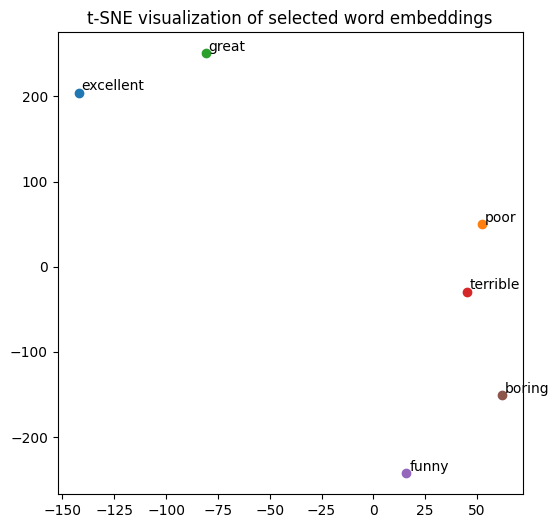

In [7]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Define your own list of words to visualize
words_to_visualize = ["excellent", "poor", "great", "terrible", "funny", "boring"]

# Filter the list to only include words found in the GloVe embeddings
words_in_glove = [word for word in words_to_visualize if word in glove_embeddings]

# Extract the vectors for the filtered words
word_vectors = np.array([glove_embeddings[word] for word in words_in_glove])

# Perform t-SNE
tsne = TSNE(n_components=2, perplexity=len(words_in_glove)/3, random_state=0)
word_vectors_reduced = tsne.fit_transform(word_vectors)

# Plot
plt.figure(figsize=(6, 6))
for i, word in enumerate(words_in_glove):
    plt.scatter(word_vectors_reduced[i, 0], word_vectors_reduced[i, 1])
    plt.annotate(word, xy=(word_vectors_reduced[i, 0], word_vectors_reduced[i, 1]), xytext=(2, 2), textcoords='offset points')

plt.title('t-SNE visualization of selected word embeddings')
plt.show()

# Prepare Data for Model

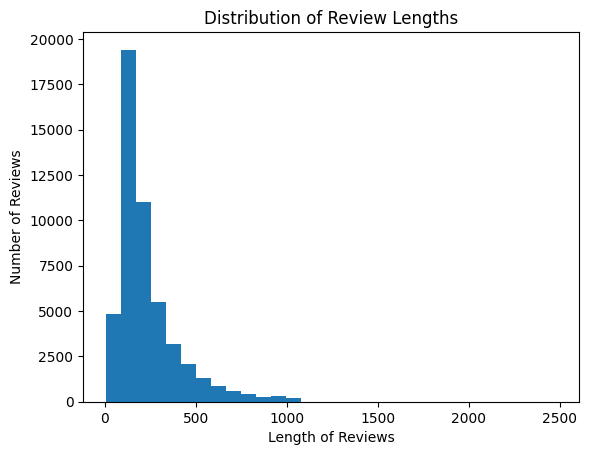

In [8]:
import matplotlib.pyplot as plt

review_lengths = [len(review.split()) for review in all_reviews]

# Plot distribution of review lengths
plt.hist(review_lengths, bins=30)
plt.title('Distribution of Review Lengths')
plt.xlabel('Length of Reviews')
plt.ylabel('Number of Reviews')
plt.show()

In [9]:
# Choose max_length that covers most data, using percentile
max_length = int(np.percentile(review_lengths, 85))
print(f"Chosen max_length: {max_length}")

Chosen max_length: 376


In [10]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_reviews)
sequences = tokenizer.texts_to_sequences(all_reviews)

# Pad sequences
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='pre')

# Convert labels to classes
labels = data['sentiment'].map({'positive': 1, 'negative': 0}).values


# Split data
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# Model

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D

# Define LSTM model
model = Sequential()

num_words = len(tokenizer.word_index) + 1
embedding_dim = vector_size

# Initialize embedding matrix with zeros
embedding_matrix = np.zeros((num_words, embedding_dim))


for word, index in tokenizer.word_index.items():
    vector = glove_embeddings.get(word)
    if vector is not None:
        embedding_matrix[index] = vector


model.add(Embedding(input_dim=embedding_matrix.shape[0],
                    output_dim=embedding_matrix.shape[1],
                    weights=[embedding_matrix],
                    input_length=max_length,
                    trainable=False))

model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 376, 300)          30384000  
                                                                 
 spatial_dropout1d (Spatial  (None, 376, 300)          0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 376, 64)           93440     
                                                                 
 dropout (Dropout)           (None, 376, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                        

# Model Training

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=128,
                    validation_split=0.1,
                    callbacks=[early_stopping])

# Evaluate model on the test set
test_metrics = model.evaluate(X_test, y_test)

# Output evaluation results
print(f"Test Loss: {test_metrics[0]}")
print(f"Test Accuracy: {test_metrics[1]}")

Epoch 1/20
282/282 [==============================] - 414s 1s/step - loss: 0.5316 - accuracy: 0.7366 - val_loss: 0.4040 - val_accuracy: 0.8263
Epoch 2/20
282/282 [==============================] - 408s 1s/step - loss: 0.3600 - accuracy: 0.8469 - val_loss: 0.2912 - val_accuracy: 0.8752
Epoch 3/20
282/282 [==============================] - 405s 1s/step - loss: 0.3097 - accuracy: 0.8724 - val_loss: 0.2791 - val_accuracy: 0.8882
Epoch 4/20
282/282 [==============================] - 421s 1s/step - loss: 0.2829 - accuracy: 0.8838 - val_loss: 0.2553 - val_accuracy: 0.8955
Epoch 5/20
282/282 [==============================] - 439s 2s/step - loss: 0.2692 - accuracy: 0.8906 - val_loss: 0.2584 - val_accuracy: 0.8988
Epoch 6/20
282/282 [==============================] - 433s 2s/step - loss: 0.2538 - accuracy: 0.8984 - val_loss: 0.2496 - val_accuracy: 0.9043
Epoch 7/20
282/282 [==============================] - 432s 2s/step - loss: 0.2483 - accuracy: 0.9001 - val_loss: 0.2350 - val_accuracy: 0.9038

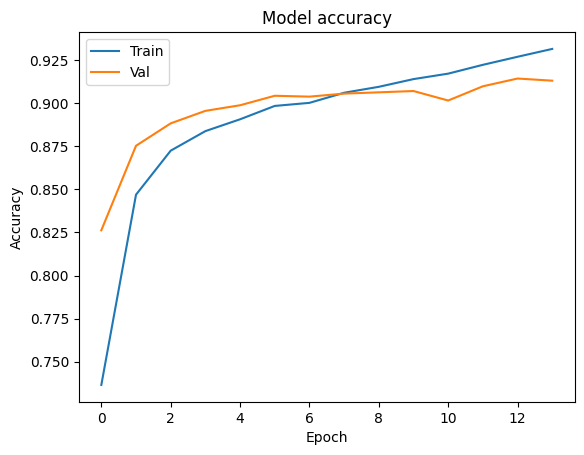

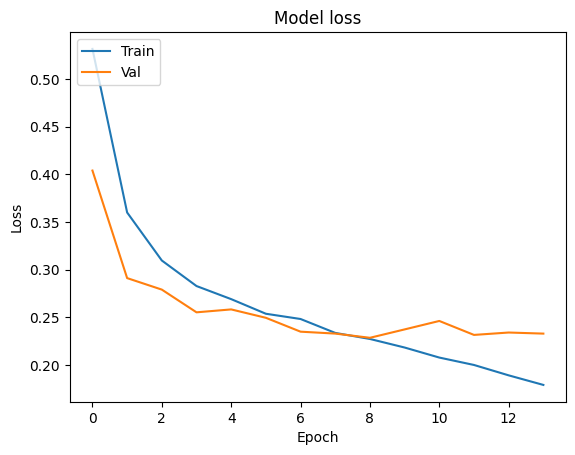

In [13]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Model Evaluation

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predictions
y_pred = model.predict(X_test)

# Threshold predictions for binary classification
y_pred = (y_pred > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

313/313 [==============================] - 73s 229ms/step
Accuracy: 0.9031
Precision: 0.8971506635441062
Recall: 0.9122841833697162
F1 Score: 0.9046541375578078


# Predictions

In [15]:
def predict_sentiment(text, tokenizer, model, max_length):
    # Clean text
    cleaned_text = clean_text([text])
    # Tokenize text
    sequence = tokenizer.texts_to_sequences(cleaned_text)
    # Pad sequences
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='pre')
    # Predict
    prediction = model.predict(padded_sequence)

    # Access the 1st element of prediction array & convert
    confidence = float(prediction[0][0])

    if prediction >= 0.5:
        return "positive", confidence
    else:
        return "negative", confidence

# Usage
sample_review1 = "The movie was not great. I really expected action but there was none of that!"
sentiment, confidence = predict_sentiment(sample_review1, tokenizer, model, max_length)
print(f"Sentiment: {sentiment}, Confidence: {confidence:.4f}")

sample_review2 = "This film was a joy to watch. Brilliant acting and a compelling story!"
sentiment, confidence = predict_sentiment(sample_review2, tokenizer, model, max_length)
print(f"Sentiment: {sentiment}, Confidence: {confidence:.4f}")

1/1 [==============================] - 0s 152ms/step
Sentiment: negative, Confidence: 0.3247
1/1 [==============================] - 0s 196ms/step
Sentiment: positive, Confidence: 0.9705
